TODO:  replace all str_tokens_sw with raw_news

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from __future__ import division
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler

In [2]:
labels = pd.read_csv('stocknews//labels.csv', header=None)

http://stackoverflow.com/questions/28382735/python-pandas-does-not-read-the-first-row-of-csv-file

`pd.read_csv` was cutting off the first row of labels.

`header=None` prevents that from happening.

In [3]:
# Confirm size of labels to make sure data loaded correctly
labels.shape

(1989, 1)

In [4]:
news = pd.read_csv('stocknews/Combined_News_DJIA.csv', dtype=str, keep_default_na=False)

In [5]:
raw_news = news.iloc[:,2:]

In [6]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/home/kt12/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [7]:
sid = SentimentIntensityAnalyzer()

In [8]:
"""
Showed differences between raw_news with puncuation vs tokenized news
"""
#for k in range(len(raw_news.ix[4])):
#    print sid.polarity_scores(raw_news.ix[k, 2])['compound'] - sid.polarity_scores(str_tokens_sw.ix[k,2])['compound']

'\nShowed differences between raw_news with puncuation vs tokenized news\n'

In [9]:
def compound_sentiment(element):
    return sid.polarity_scores(element)['compound']

In [10]:
sentiment_raw = raw_news.applymap(compound_sentiment)

In [11]:
raw_all_sent = []
for j in range(len(sentiment_raw.index)):
    for k in range(len(sentiment_raw.columns)):
        raw_all_sent.append(sentiment_raw.ix[j,k])

/home/kt12/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


In [12]:
len(raw_all_sent)

49725

In [13]:
sum(1 for k in raw_all_sent if k == 0.0)

12128

#### Still a lot of 0's in sentiment ####

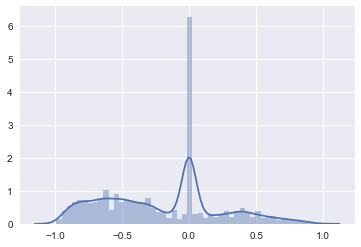

In [14]:
sns.distplot(raw_all_sent)

In [15]:
EMA = pd.Series.ewm(sentiment_raw.ix[2], com=12).mean()
EMA

Top1     0.025800
Top2     0.012384
Top3    -0.274766
Top4    -0.369562
Top5    -0.283371
Top6    -0.365549
Top7    -0.407484
Top8    -0.438703
Top9    -0.322037
Top10   -0.383893
Top11   -0.438096
Top12   -0.438383
Top13   -0.488423
Top14   -0.432673
Top15   -0.325379
Top16   -0.290720
Top17   -0.260643
Top18   -0.226594
Top19   -0.263291
Top20   -0.294378
Top21   -0.266552
Top22   -0.192868
Top23   -0.140326
Top24   -0.127680
Top25   -0.116323
Name: 2, dtype: float64

### Set up Pandas series to get median, mean, exponentially weighted mean

In [16]:
median_sent = pd.Series(index=sentiment_raw.index)

In [17]:
mean_sent = pd.Series(index=sentiment_raw.index)

In [18]:
exp_mean = pd.Series(index=sentiment_raw.index)

In [19]:
sum_5 = pd.Series(index=sentiment_raw.index)

In [20]:
weighted_5 = pd.Series(index=sentiment_raw.index)

In [21]:
for k in range(len(sentiment_raw.index)):
    median_sent[k] = sentiment_raw.iloc[k].median()

In [22]:
for k in range(len(sentiment_raw.index)):
    mean_sent[k] = sentiment_raw.iloc[k].mean()

In [23]:
a = sentiment_raw.ix[2][::-1]

In [24]:
for k in range(len(sentiment_raw.index)):
    exp_mean[k] = pd.stats.moments.ewma(sentiment_raw.ix[k], span=25).mean()

/home/kt12/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=25,min_periods=0,adjust=True,ignore_na=False).mean()
  


In [25]:
sum(sentiment_raw.iloc[4,:5])

-0.59820000000000007

In [26]:
sentiment_raw.iloc[4]

Top1     0.2023
Top2     0.0000
Top3     0.6808
Top4    -0.8689
Top5    -0.6124
Top6    -0.6369
Top7     0.7177
Top8    -0.4404
Top9    -0.6808
Top10   -0.3400
Top11    0.0000
Top12    0.0000
Top13    0.0000
Top14    0.1779
Top15    0.0000
Top16   -0.6249
Top17    0.0000
Top18    0.0000
Top19    0.0000
Top20    0.0000
Top21   -0.4404
Top22   -0.5994
Top23    0.1779
Top24   -0.6908
Top25    0.7096
Name: 4, dtype: float64

In [27]:
sum_sent = pd.Series(index=sentiment_raw.index)

In [28]:
for k in range(len(sentiment_raw.index)):
    sum_sent[k] = sentiment_raw.iloc[k].sum()

In [29]:
for k in range(len(sentiment_raw.index)):
    sum_5[k] = sum(sentiment_raw.iloc[k,:5])

In [30]:
sum(1 for k in sum_sent if k > 0)

20

In [31]:
sum(1 for k in exp_mean if k > 0 )

61

In [32]:
w = np.array([5,4,3,2,1])
for k in range(len(sentiment_raw.index)):
    weighted_5[k] = np.dot(pd.Series([j for j in sentiment_raw.iloc[k] if j != 0][0:5]), w)

In [33]:
weighted_5.head()

0   -8.6937
1    3.2395
2   -6.8272
3   -9.4989
4   -0.7337
dtype: float64

In [34]:
features = pd.concat([mean_sent, median_sent, exp_mean, sum_5, weighted_5], axis=1)

In [35]:
mean_sent.head(2)

0   -0.30944
1   -0.12074
dtype: float64

In [36]:
median_sent.head(2)

0   -0.2755
1   -0.0772
dtype: float64

In [37]:
exp_mean.head(2)

0   -0.356407
1   -0.027896
dtype: float64

In [38]:
features.columns = ['Mean Sentiment', 'Median Sentiment', 'Exponential Weighted Sentiment', 'Sum Top 5 Sentiment', 'Top 5 Weighted Sentiment']

In [39]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 5 columns):
Mean Sentiment                    1989 non-null float64
Median Sentiment                  1989 non-null float64
Exponential Weighted Sentiment    1989 non-null float64
Sum Top 5 Sentiment               1989 non-null float64
Top 5 Weighted Sentiment          1989 non-null float64
dtypes: float64(5)
memory usage: 77.8 KB


In [40]:
features.describe()

Mean Sentiment  Median Sentiment  Exponential Weighted Sentiment  \
count     1989.000000       1989.000000                     1989.000000   
mean        -0.211690         -0.192107                       -0.210190   
std          0.092483          0.175418                        0.113641   
min         -0.520204         -0.670500                       -0.572329   
25%         -0.273356         -0.340000                       -0.286806   
50%         -0.209492         -0.200600                       -0.210205   
75%         -0.149388          0.000000                       -0.133064   
max          0.132324          0.025800                        0.170866   

       Sum Top 5 Sentiment  Top 5 Weighted Sentiment  
count          1989.000000               1989.000000  
mean             -1.056032                 -4.079373  
std               1.033127                  3.756724  
min              -4.154500                -12.621600  
25%              -1.789700                 -6.903700  
50%              -1.085400                 -4.294300  
75%              -0.347200                 -1.570700  
max               2.184900                  8.533300

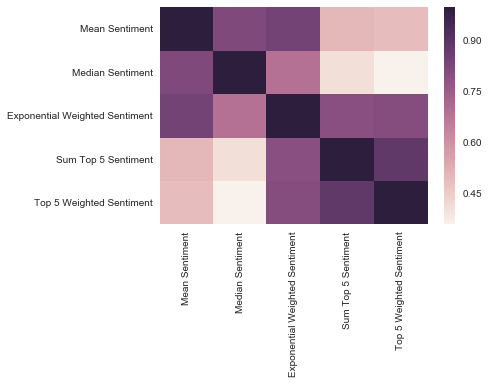

In [41]:
sns.heatmap(features.corr())

## Split data into train and test sets

In [42]:
train_text = features[0:1493] # train features

In [43]:
test_text = features[1493:] # test features

In [44]:
train_labels = labels[0:1493].values # train labels

In [45]:
test_labels = labels[1493:].values; # test labels

In [46]:
# Use Robust Scaler to rescale data
rs = RobustScaler()
train_text_scaled = rs.fit_transform(train_text)
test_text_scaled = rs.transform(test_text)

### Passive Aggressive Classifier

In [47]:
# Set up GridSearch

param_grid = {'loss'  : ['hinge', 'squared_hinge'],
              'C': [10**x for x in np.linspace(-8, 4, 13)]}

In [48]:
from sklearn.linear_model import PassiveAggressiveClassifier

In [49]:
classifier = PassiveAggressiveClassifier(fit_intercept=True,
                                         random_state=0,
                                         n_iter=8)

In [50]:
clf_grid = GridSearchCV(estimator=classifier, param_grid=param_grid, n_jobs=-1, scoring='roc_auc')

In [51]:
clf_grid.fit(train_text_scaled, train_labels.ravel())

GridSearchCV(cv=None, error_score='raise',
       estimator=PassiveAggressiveClassifier(C=1.0, class_weight=None, fit_intercept=True,
              loss='hinge', n_iter=8, n_jobs=1, random_state=0,
              shuffle=True, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'loss': ['hinge', 'squared_hinge'], 'C': [1e-08, 9.9999999999999995e-08, 9.9999999999999995e-07, 1.0000000000000001e-05, 0.0001, 0.001, 0.01, 0.10000000000000001, 1.0, 10.0, 100.0, 1000.0, 10000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [52]:
clf_grid.best_estimator_

PassiveAggressiveClassifier(C=1.0000000000000001e-05, class_weight=None,
              fit_intercept=True, loss='squared_hinge', n_iter=8, n_jobs=1,
              random_state=0, shuffle=True, verbose=0, warm_start=False)

In [53]:
clf_grid.best_params_

{'C': 1.0000000000000001e-05, 'loss': 'squared_hinge'}

In [54]:
clf_grid.best_score_

0.54203375034784462

In [55]:
y_true, y_pred = test_labels.ravel(), clf_grid.predict(test_text_scaled)

In [56]:
from sklearn.metrics import classification_report

In [57]:
classification_report(y_true, y_pred)

'             precision    recall  f1-score   support\n\n          0       0.51      0.17      0.26       240\n          1       0.52      0.84      0.64       256\n\navg / total       0.51      0.52      0.46       496\n'

### SGD Classifier

In [58]:
from sklearn.linear_model import SGDClassifier

In [59]:
classifier = SGDClassifier(loss='squared_loss', n_iter=25)

In [60]:
classifier.fit(train_text, train_labels.ravel())

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='squared_loss', n_iter=25, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [61]:
classifier.score(test_text, test_labels.ravel())

0.47983870967741937

### Logisitc Regression

In [62]:
from sklearn.linear_model import LogisticRegression

In [63]:
logr = LogisticRegression()

In [64]:
logr.fit(train_text, train_labels.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [65]:
logr.score(test_text, test_labels.ravel())

0.51209677419354838

### Ridge Classifier

In [66]:
from sklearn.linear_model import RidgeClassifier

In [67]:
clf = RidgeClassifier()

In [68]:
clf.fit(train_text, train_labels.ravel())

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)

In [69]:
clf.score(test_text, test_labels.ravel())

0.50604838709677424

### Gassian NB

In [70]:
from sklearn.naive_bayes import GaussianNB

In [71]:
gnb = GaussianNB()

In [72]:
gnb.fit(train_text, train_labels.ravel())

GaussianNB(priors=None)

In [73]:
gnb.score(test_text, test_labels.ravel())

0.47177419354838712

### Support Vector Classifier

In [74]:
from sklearn.svm import SVC

In [75]:
supportvc = SVC()

In [76]:
supportvc.fit(train_text, train_labels.ravel())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [77]:
supportvc.score(test_text, test_labels.ravel())

0.52217741935483875

### Random Forests

In [78]:
from sklearn.ensemble import RandomForestClassifier

In [79]:
rfc = RandomForestClassifier()

In [80]:
rfc.fit(train_text, train_labels.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [81]:
rfc.score(test_text, test_labels.ravel())

0.50201612903225812

### Adaboost

In [82]:
from sklearn.ensemble import AdaBoostClassifier

In [83]:
abc = AdaBoostClassifier()

In [84]:
abc.fit(train_text, train_labels.ravel())

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [85]:
abc.score(test_text, test_labels.ravel())

0.50201612903225812